In [1]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision.transforms as transforms
import torchvision.transforms.v2 as T
from torchvision.models import convnext_base
from torchvision.models.vision_transformer import vit_b_16, vit_l_16
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil


In [2]:
#Train you own model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, save_path='best_model.pth', log_file='training_log.txt'):    
    torch.cuda.empty_cache()  # Clear memory
    train_losses, val_losses = [], []
    train_accs, train_f1s, val_accs, val_f1s = [], [], [], []
    
    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_val_loss = float('inf')
    
    for epoch in range(0, num_epochs+0):
        start_time = time.time()
        print(f"Starting Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_all_preds, train_all_labels = [], []
        for images, labels, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            train_all_preds.append(predicted.cpu().view(-1))  # Ensure shape is (N,)
            train_all_labels.append(labels.cpu().view(-1))    # Ensure shape is (N,)

        # Compute F1-Score after epoch
        if train_all_preds:
            train_all_preds = torch.cat(train_all_preds).numpy()
            train_all_labels = torch.cat(train_all_labels).numpy()
        else:
            train_all_preds = np.array([])
            train_all_labels = np.array([])

        train_f1 = f1_score(train_all_labels, train_all_preds, average='binary') * 100      
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_all_preds, val_all_labels = [], []
        
        with torch.no_grad():
            for images, labels, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                val_all_preds.append(predicted.cpu().view(-1))
                val_all_labels.append(labels.cpu().view(-1))
                
        if val_all_preds:
            val_all_preds = torch.cat(val_all_preds).numpy()
            val_all_labels = torch.cat(val_all_labels).numpy()
        else:
            val_all_preds = np.array([])
            val_all_labels = np.array([])

        val_f1 = f1_score(val_all_labels, val_all_preds, average='binary') * 100
                
        val_loss /= len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_time = end_time - start_time
        log_message = f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train F1: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.2f}% | Time: {epoch_time:.2f} sec"
        print(log_message)
        with open(log_file, 'a') as f:
            f.write(log_message + '\n')

        # Save best model
        if val_f1 > best_val_f1 or (val_f1 == best_val_f1 and val_loss < best_val_loss):
            best_val_f1, best_val_loss = val_f1, val_loss
            model_filename = f"best_model_epoch{epoch+1}_f1{best_val_f1:.2f}_loss{best_val_loss:.4f}.pth"
            torch.save(model.state_dict(), model_filename)
            log_message = f"Best model saved with Val F1: {best_val_f1:.2f}% and Val Loss:{best_val_loss}"
            print(log_message)
            with open(log_file, 'a') as f:
                f.write(log_message + '\n')
        else:  #Save model for each epoch
            model_filename = f"best_model_epoch{epoch+1}_f1{val_f1:.2f}_loss{val_loss:.4f}.pth"
            torch.save(model.state_dict(), model_filename)
            log_message = f"Model saved with Val F1: {val_f1:.2f}% and Val Loss:{val_loss}"
            print(log_message)
            with open(log_file, 'a') as f:
                f.write(log_message + '\n')
                
        submission(model, epoch=epoch+1)
       
        
        
        # Step the Learning Rate Scheduler AFTER Validation
        scheduler.step(val_loss)
        torch.cuda.empty_cache()  # Clear unused memory
    
    # Plot loss and accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(range(1, num_epochs+1), train_f1s, label='Train F1')
    plt.plot(range(1, num_epochs+1), val_f1s, label='Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 (%)')
    plt.title('Training and Validation F1')
    plt.legend()

    plt.tight_layout()
    
    plt.savefig('training_metrics.png')  # Save single plot instead of multiple
    plt.show()



In [3]:
def analyze_unknown_dataset(folder_path):
    """
    Analyze brightness, contrast, and blur from a sample of images in the unknown dataset.
    
    Parameters:
    - folder_path (str): Path to the unknown dataset directory.
    - sample_size (int): Number of images to sample for analysis (default=100).

    Returns:
    - brightness_mean (float): Normalized brightness value.
    - contrast_mean (float): Normalized contrast value.
    - blur_mean (float): Blur estimation.
    - brightness_jitter (float): Jittered brightness for training augmentation.
    - contrast_jitter (float): Jittered contrast for training augmentation.
    - blur_radius (float): Blur radius for training augmentation.
    """
    brightness_vals, contrast_vals, blur_vals = [], [], []
    file_names = os.listdir(folder_path)  # Sample a subset of images
    
    for file_name in file_names:
        img_path = os.path.join(folder_path, file_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Brightness: Mean pixel intensity
            brightness_vals.append(np.mean(img_gray))

            # Contrast: Standard deviation of pixel intensity
            contrast_vals.append(np.std(img_gray))

            # Blur level: Variance of Laplacian (higher value = sharper image)
            blur_vals.append(cv2.Laplacian(img_gray, cv2.CV_64F).var())

    # Compute means
    brightness_mean = np.mean(brightness_vals) / 255.0  # Normalize to [0,1]
    contrast_mean = np.mean(contrast_vals) / 128.0  # Normalize contrast
    blur_mean = np.mean(blur_vals)  # Keep original scale

    # Define jitter ranges for training augmentation
    brightness_jitter = max(0.1, min(0.5, brightness_mean))  
    contrast_jitter = max(0.1, min(0.5, contrast_mean))  
    blur_radius = max(0.1, min(3.0, 100 / (blur_mean + 1e-5)))  

    return brightness_mean, contrast_mean, blur_mean, brightness_jitter, contrast_jitter, blur_radius

# Path to unknown dataset
unknown_path = "/kaggle/input/ai-vs-human-generated-dataset/test_data_v2"

#brightness_u, contrast_u, blur_u, brightness_jitter, contrast_jitter, blur_radius = analyze_unknown_dataset(unknown_path)
brightness_u, contrast_u, blur_u = 0.5432116346676609,  0.45733990203840624, 858.7081241640982
brightness_jitter, contrast_jitter, blur_radius = 0.5, 0.45733990203840624, 0.11645400342846887

print(f"Extracted Unknown Dataset Statistics:")
print(f"- Brightness (Fixed for Validation): {brightness_u}")
print(f"- Contrast (Fixed for Validation): {contrast_u}")
print(f"- Blur (Fixed for Validation): {blur_u}")
print(f"- Brightness Jitter (Training): {brightness_jitter}")
print(f"- Contrast Jitter (Training): {contrast_jitter}")
print(f"- Blur Radius (Training): {blur_radius}")

Extracted Unknown Dataset Statistics:
- Brightness (Fixed for Validation): 0.5432116346676609
- Contrast (Fixed for Validation): 0.45733990203840624
- Blur (Fixed for Validation): 858.7081241640982
- Brightness Jitter (Training): 0.5
- Contrast Jitter (Training): 0.45733990203840624
- Blur Radius (Training): 0.11645400342846887


In [4]:
#Define transformations for training dataset
class TrainTransform(Dataset):
    def __init__(self, dataset): #pd.read_csv(excel_file, header=0) #[:100] #for tial if codes can run

        self.data = dataset
        self.image_paths = self.data.iloc[:, 1].values  # Column 1: Image paths
        self.labels = self.data.iloc[:, 2].values  # Column 2: Labels (0 or 1)
            
        """
        self.train_transform = transforms.Compose([
            transforms.Resize(232),  # Resize to match ConvNeXt preprocessing
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.train_transform = transforms.Compose([
            transforms.Resize(232),  # Resize to match ConvNeXt preprocessing
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
            transforms.ColorJitter(brightness=brightness_jitter, contrast=contrast_jitter, saturation=0.2, hue=0.05),  # Auto-tuned color jitter
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random affine transformations
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective distortion
            transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=blur_radius))),  # Auto-tuned blur effect
            transforms.Lambda(lambda img: img.convert("RGB").convert("P", palette=Image.ADAPTIVE).convert("RGB")),  # Simulate color banding
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x)),  # Add small Gaussian noise for robustness
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
        ])
        """

        self.train_transform_fake = T.Compose([
            T.Resize(300),  # Resize to match ConvNeXt preprocessing
            #T.RandomResizedCrop(224, scale=(0.8, 1.0)),
            T.RandomRotation(degrees=30),
            T.CenterCrop(224), 
            T.ColorJitter(
                    brightness=(0.2, 1.2),  # Adjust brightness between 20% and 120%
                    contrast=(0.1, 1.5),    # Adjust contrast between 30% and 150%
                    saturation=(0.1, 1.2),  # Adjust saturation between 10% and 120%
                    hue=(-0.2, 0.2)         # Adjust hue within ±20% of 180° color spectrum
                ),
            T.RandomAutocontrast(p=0.5),  # Randomly apply autocontrast
            T.GaussianBlur(kernel_size=5, sigma=(0.3, 2.0)),
            #T.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            #T.RandomErasing(p=0.3),  # Add random erasing for regularization
            T.ToTensor(),
            T.GaussianNoise(mean=0.0, sigma=0.05, clip=True),  # Add Gaussian noise
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        """
        self.train_transform = T.Compose([
            T.Resize(232),  # Resize to match ConvNeXt preprocessing
            T.RandomResizedCrop(224, scale=(0.8, 1.0)),
            T.RandomRotation(degrees=30),
            T.ColorJitter(
                    brightness=(0.2, 1.2),  # Adjust brightness between 20% and 120%
                    contrast=(0.1, 1.5),    # Adjust contrast between 30% and 150%
                    saturation=(0.1, 1.2),  # Adjust saturation between 10% and 120%
                    hue=(-0.2, 0.2)         # Adjust hue within ±20% of 180° color spectrum
                ),
            T.RandomAutocontrast(p=0.5),  # Randomly apply autocontrast
            T.GaussianBlur(kernel_size=5, sigma=(0.3, 2.0)),
            T.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            T.RandomErasing(p=0.3),  # Add random erasing for regularization
            T.ToTensor(),
            T.GaussianNoise(mean=0.0, sigma=0.05, clip=True),  # Add Gaussian noise
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        """

        self.train_transform_real = T.Compose([
            T.Resize(232),  # Resize to 232 as per ConvNeXt documentation
            T.CenterCrop(224), 
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = "/kaggle/input/ai-vs-human-generated-dataset/"+self.image_paths[idx]
        label = self.labels[idx]
        ImageRGB = Image.open(image_path).convert("RGB")
        imageTran = self.train_transform_fake(ImageRGB)
        
        """        
        if label == 1:
            imageTran = self.train_transform_fake(ImageRGB)
        else:
            imageTran = self.train_transform_real(ImageRGB)
        """
        return imageTran, label, image_path

#Define transformations for validtion and testing dataset
class ValiTestTransform(Dataset):
    def __init__(self, dataset): #pd.read_csv(excel_file, header=0) #[:100] #for tial if codes can run

        self.data = dataset
        self.image_paths = self.data.iloc[:, 1].values  # Column 1: Image paths
        self.labels = self.data.iloc[:, 2].values  # Column 2: Labels (0 or 1)

        """
        self.val_test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=brightness_u, contrast=contrast_u, saturation=0.1, hue=0.02),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 100 / (blur_u + 1e-5))),  # Dynamic blur effect
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        """
        self.train_transform = T.Compose([
            T.Resize(232),  # Resize to 232 as per ConvNeXt documentation
            T.CenterCrop(224), 
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = "/kaggle/input/ai-vs-human-generated-dataset/"+self.image_paths[idx]
        label = self.labels[idx]
        ImageRGB = Image.open(image_path).convert("RGB")
        imageTran = self.train_transform(ImageRGB)
    
        
        return imageTran, label, image_path

#Define transformations for unknonwn dataset
class UnknownTransform(Dataset):
    def __init__(self, dataset): #pd.read_csv(excel_file, header=0) #[:100] #for tial if codes can run

        self.data = dataset
        self.image_paths = self.data.iloc[:, 0].values
            

        self.unknown_transform = T.Compose([
            T.Resize(232),  # Resize to 232 as per ConvNeXt documentation
            T.CenterCrop(224), 
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = "/kaggle/input/ai-vs-human-generated-dataset/"+self.image_paths[idx]
        ImageRGB = Image.open(image_path).convert("RGB")
        imageTran = self.unknown_transform(ImageRGB)
    
        
        return imageTran, image_path

def get_class_distribution(data_loader):
    """
    Counts the number of occurrences of each class label in a DataLoader.

    Args:
        data_loader (DataLoader): The PyTorch DataLoader (e.g., test_loader).

    Returns:
        dict: A dictionary where keys are class labels and values are their counts.
    """
    class_counts = Counter()

    # Loop through data_loader and count labels
    for _, labels, _ in data_loader:
        class_counts.update(labels.cpu().numpy())  # Convert tensor to NumPy and count

        # Print class distribution
    for class_label, count in sorted(class_counts.items()):
        print(f"Class {class_label}: {count} samples")


def submission(model, epoch=14, saveImg = False):
    model.eval()
    unknown_dataset = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/test.csv", header=0)
    unknown_dataset = UnknownTransform(unknown_dataset)
    if saveImg:
        unknown_loader = DataLoader(unknown_dataset, batch_size=1, shuffle=False, num_workers=4)
    else:
        unknown_loader = DataLoader(unknown_dataset, batch_size=32, shuffle=False, num_workers=4)
        
    unknown_logits = []
    unknown_pred = []
    os.makedirs('testPred', exist_ok=True)
    with torch.no_grad():
        n = 1
        for images, image_path in tqdm(unknown_loader, desc="Unknown Predictions"):
            images = images.to(device)
            outputs = model(images)
            unknown_logits.extend(outputs.cpu().numpy())
            preds = outputs.argmax(dim=1)
            predslabel = preds.cpu().numpy()
            unknown_pred.extend(predslabel)
            #save predict imgs:
            if saveImg:
                plt.figure(figsize=(4,6))
                image_path = image_path[0]
                img = Image.open(image_path)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Prediction: {predslabel[0]}")
                plt.savefig(f"testPred/{n}_pred_{predslabel[0]}_{os.path.basename(image_path)}", bbox_inches='tight')
                plt.close()
                n+=1
    

    shutil.make_archive("testPred", 'zip', "testPred")
    print("Zipped testPred folder successfully!")
    
    unknown_excel = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/test.csv", header=0)
    
    unknown_logits_df = pd.DataFrame(unknown_logits, columns=['logit_cla_0', 'logit_cla_1'])
    unknown_logits_df['id'] = unknown_excel['id'].values 
    
    unknown_excel['label'] = unknown_pred
    class_counts = unknown_excel['label'].value_counts()
    print(class_counts)
    unknown_excel.to_csv(f"{epoch}_{class_counts[1]}_unknown.csv", index=False)
    unknown_logits_df.to_csv(f'{epoch}_{class_counts[1]}_unknown_logits.csv', index=False)
    print("Predictions saved to unknown.csv")
    #Actual 1s (TP) = 2767.
    #Actual 0s (TN) = 2773.

In [5]:
full_dataset = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/train.csv", header=0)

# Ensure the dataset has at least some samples
dataset_size = len(full_dataset)

# Define split sizes
train_ratio = 0.95
val_ratio = 0.03
test_ratio = 1 - (train_ratio + val_ratio)  # Ensures all data is used

train_dataset, temp_data = train_test_split(full_dataset, test_size=(1 - train_ratio), random_state=42, shuffle=False)
val_dataset, test_dataset = train_test_split(temp_data, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, shuffle=False)
train_dataset = TrainTransform(train_dataset)
val_dataset = ValiTestTransform(val_dataset)
test_dataset = ValiTestTransform(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Training Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")
print(f"Testing Set Size: {len(test_dataset)}")
get_class_distribution(test_loader)

"""
# Confirm dataset sizes
print(f"Total Dataset Size: {dataset_size}")
print(f"Training Set Size: {len(train_dataset)}")
get_class_distribution(train_loader)
print(f"Validation Set Size: {len(val_dataset)}")
get_class_distribution(val_loader)
print(f"Testing Set Size: {len(test_dataset)}")
get_class_distribution(test_loader)
"""



Training Set Size: 75952
Validation Set Size: 2398
Testing Set Size: 1600


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Class 0: 800 samples
Class 1: 800 samples


'\n# Confirm dataset sizes\nprint(f"Total Dataset Size: {dataset_size}")\nprint(f"Training Set Size: {len(train_dataset)}")\nget_class_distribution(train_loader)\nprint(f"Validation Set Size: {len(val_dataset)}")\nget_class_distribution(val_loader)\nprint(f"Testing Set Size: {len(test_dataset)}")\nget_class_distribution(test_loader)\n'

tensor(0)


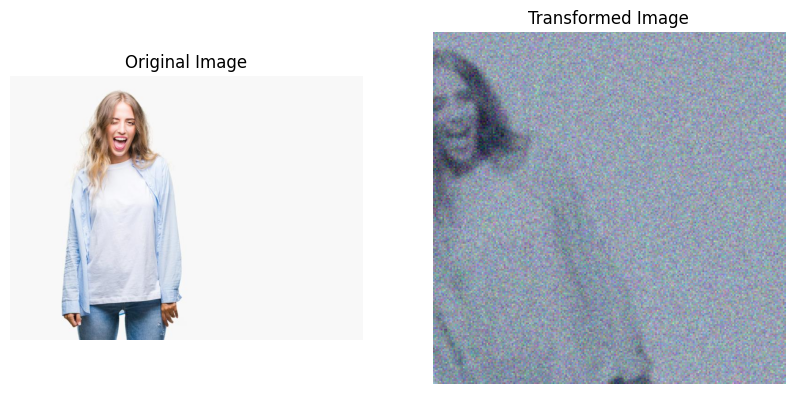

In [6]:

import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

for imageTran, label, image_path in train_loader:
    print(label[0])
    # Load the original image using PIL
    original_image = Image.open(image_path[0])  # image_path[0] because image_path is a batch
    
    # Convert the transformed image from (C, H, W) to (H, W, C)
    transformed_image = imageTran[0].permute(1, 2, 0).numpy()
    
    # Clip the transformed image to ensure pixel values are in range [0, 1]
    transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the transformed image
    axes[1].imshow(transformed_image)
    axes[1].set_title("Transformed Image")
    axes[1].axis('off')

    plt.show()
    break


In [7]:
"""
# Load Vision Transformer model

model = vit_l_16(pretrained=True) #vit_l_16 vit_b_16
model.heads.head = torch.nn.Linear(model.heads.head.in_features, 2)  # 2 classes: Real & Fake

model = convnext_base(weights="DEFAULT") #pretrained=True)
model.classifier[-1] = nn.Linear(1024, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)
"""

# Load pretrained ConvNeXt Base model
model = convnext_base(weights="DEFAULT")

# Freeze all layers initially
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the last two stages
for param in model.features[-2:].parameters():
    param.requires_grad = True

# Replace the classifier head with a custom one
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
    nn.Flatten(),                  # Flatten the tensor
    nn.BatchNorm1d(1024),          # Add BatchNorm here
    nn.Linear(1024, 512),          # First fully connected layer
    nn.ReLU(),                     # Activation function
    nn.Dropout(0.4),               # Dropout for regularization
    nn.Linear(512, 2)              # Output layer (binary classification)
)

# Move the model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load_path = "/kaggle/input/0.77963-best_model_epoch15_f193.90_loss0.1541/pytorch/default/1/0.77963-best_model_epoch15_f193.90_loss0.1541.pth"
model.load_state_dict(torch.load(load_path, map_location=device))
model = model.to(device)

# Define loss function, optimizer, and learning rate scheduler
optimizer = torch.optim.AdamW([
    {'params': model.features[-2:].parameters(), 'lr': 1e-5},  # Lower LR for backbone
    {'params': model.classifier.parameters(), 'lr': 1e-4}      # Higher LR for classifier
])

criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:04<00:00, 79.4MB/s]
<ipython-input-7-882a72afad67>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of t

In [8]:
# Train the model
#train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=3)

In [9]:
import shutil

def submission(model, epoch=14, saveImg = False):
    model.eval()
    unknown_dataset = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/test.csv", header=0)
    unknown_dataset = UnknownTransform(unknown_dataset)
    if saveImg:
        unknown_loader = DataLoader(unknown_dataset, batch_size=1, shuffle=False, num_workers=4)
    else:
        unknown_loader = DataLoader(unknown_dataset, batch_size=32, shuffle=False, num_workers=4)
        
    unknown_logits = []
    unknown_pred = []
    os.makedirs('test3Pred', exist_ok=True)
    with torch.no_grad():
        n = 1
        for images, image_path in tqdm(unknown_loader, desc="Unknown Predictions"):
            images = images.to(device)
            outputs = model(images)
            unknown_logits.extend(outputs.cpu().numpy())
            preds = outputs.argmax(dim=1)
            predslabel = preds.cpu().numpy()
            unknown_pred.extend(predslabel)
            #save predict imgs:
            if saveImg:
                image_path = image_path[0]
                source_path = image_path
                destination_path = f"test3Pred/{n}_pred_{predslabel[0]}_{os.path.basename(image_path)}"
                shutil.copy2(source_path, destination_path)  # copy2 preserves metadata
                """
                plt.figure(figsize=(4,6))
                image_path = image_path[0]
                img = Image.open(image_path)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Prediction: {predslabel[0]}")
                plt.savefig(f"testPred/{n}_pred_{predslabel[0]}_{os.path.basename(image_path)}", bbox_inches='tight')
                plt.close()
                """
                n+=1
    

    shutil.make_archive("test3Pred", 'zip', "test3Pred")
    print("Zipped testPred folder successfully!")
    
    unknown_excel = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/test.csv", header=0)
    
    unknown_logits_df = pd.DataFrame(unknown_logits, columns=['logit_cla_0', 'logit_cla_1'])
    unknown_logits_df['id'] = unknown_excel['id'].values 
    
    unknown_excel['label'] = unknown_pred
    class_counts = unknown_excel['label'].value_counts()
    print(class_counts)
    unknown_excel.to_csv(f"{epoch}_{class_counts[1]}_unknown.csv", index=False)
    unknown_logits_df.to_csv(f'{epoch}_{class_counts[1]}_unknown_logits.csv', index=False)
    print("Predictions saved to unknown.csv")

In [10]:
submission(model, epoch=14, saveImg = False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Unknown Predictions: 100%|██████████| 174/174 [01:12<00:00,  2.40it/s]

Zipped testPred folder successfully!
label
0    2892
1    2648
Name: count, dtype: int64
Predictions saved to unknown.csv


In [11]:
# Load trained model
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = convnext_base(pretrained=True)
model.classifier[-1] = nn.Linear(1024, 2)
load_path = "/kaggle/working/best_model_epoch4_acc90.87_loss0.2246.pth"
#"/kaggle/working/best_model_epoch1_acc78.98_loss0.4339.pth"
model.load_state_dict(torch.load(load_path, map_location=device))

model.to(device)
model.eval()
"""

'\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nmodel = convnext_base(pretrained=True)\nmodel.classifier[-1] = nn.Linear(1024, 2)\nload_path = "/kaggle/working/best_model_epoch4_acc90.87_loss0.2246.pth"\n#"/kaggle/working/best_model_epoch1_acc78.98_loss0.4339.pth"\nmodel.load_state_dict(torch.load(load_path, map_location=device))\n\nmodel.to(device)\nmodel.eval()\n'

In [12]:
# Load trained model

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = convnext_base(pretrained=True)
#model.classifier[-1] = nn.Linear(1024, 2)
#load_path = "/kaggle/input/best_model_epoch1316/pytorch/default/1/best_model_epoch13_f195.57_loss0.1106.pth"

#model.load_state_dict(torch.load(load_path, map_location=device))

#model.to(device)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels, _ in tqdm(test_loader, desc="Test Predictions"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='binary') * 100
    recall = recall_score(all_labels, all_preds, average='binary') * 100
    f1 = f1_score(all_labels, all_preds, average='binary') * 100
    
    print(f"Test Accuracy: {acc:.2f}%")
    print(f"Test Precision: {precision:.2f}%")
    print(f"Test Recall: {recall:.2f}%")
    print(f"Test F1 Score: {f1:.2f}%")

#evaluate_model(model, test_loader)



GAN

In [14]:
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

# Load Pretrained CNN (as Discriminator)
class FakeDetectionCNN(nn.Module):
    def __init__(self):
        super(FakeDetectionCNN, self).__init__()
        self.model = models.resnet18(pretrained=False)  # Assuming ResNet backbone
        self.model.fc = nn.Linear(512, 1)  # Binary classification: Real (0) vs. AI-Generated (1)
        
    def forward(self, x):
        return self.model(x)

# Load CNN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = FakeDetectionCNN().to(device)
cnn_model.load_state_dict(torch.load("cnn_trained.pth", map_location=device))
cnn_model.eval()  # Set to evaluation mode (No training for CNN)
"""

'\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torchvision import models, transforms\nfrom torchvision.utils import save_image\nfrom torch.utils.data import DataLoader, Dataset\nimport torchvision.transforms as transforms\n\n# Load Pretrained CNN (as Discriminator)\nclass FakeDetectionCNN(nn.Module):\n    def __init__(self):\n        super(FakeDetectionCNN, self).__init__()\n        self.model = models.resnet18(pretrained=False)  # Assuming ResNet backbone\n        self.model.fc = nn.Linear(512, 1)  # Binary classification: Real (0) vs. AI-Generated (1)\n        \n    def forward(self, x):\n        return self.model(x)\n\n# Load CNN model\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\ncnn_model = FakeDetectionCNN().to(device)\ncnn_model.load_state_dict(torch.load("cnn_trained.pth", map_location=device))\ncnn_model.eval()  # Set to evaluation mode (No training for CNN)\n'

In [15]:
"""
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_channels * 64 * 64),  # Output image size 64x64x3
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 3, 64, 64)  # Reshape into (batch, 3, 64, 64)

# Instantiate Generator
latent_dim = 100
generator = Generator(latent_dim=latent_dim).to(device)
"""

'\nclass Generator(nn.Module):\n    def __init__(self, latent_dim=100, img_channels=3):\n        super(Generator, self).__init__()\n        self.model = nn.Sequential(\n            nn.Linear(latent_dim, 256),\n            nn.ReLU(),\n            nn.Linear(256, 512),\n            nn.ReLU(),\n            nn.Linear(512, 1024),\n            nn.ReLU(),\n            nn.Linear(1024, img_channels * 64 * 64),  # Output image size 64x64x3\n            nn.Tanh()\n        )\n    \n    def forward(self, z):\n        img = self.model(z)\n        return img.view(-1, 3, 64, 64)  # Reshape into (batch, 3, 64, 64)\n\n# Instantiate Generator\nlatent_dim = 100\ngenerator = Generator(latent_dim=latent_dim).to(device)\n'

In [16]:
"""
full_dataset = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/train.csv", header=0)

# Ensure the dataset has at least some samples
dataset_size = len(full_dataset)

# Define split sizes
train_ratio = 0.95
val_ratio = 0.03
test_ratio = 1 - (train_ratio + val_ratio)  # Ensures all data is used

train_dataset, temp_data = train_test_split(full_dataset, test_size=(1 - train_ratio), random_state=42, shuffle=False)
val_dataset, test_dataset = train_test_split(temp_data, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, shuffle=False)

train_dataset
"""

'\nfull_dataset = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/train.csv", header=0)\n\n# Ensure the dataset has at least some samples\ndataset_size = len(full_dataset)\n\n# Define split sizes\ntrain_ratio = 0.95\nval_ratio = 0.03\ntest_ratio = 1 - (train_ratio + val_ratio)  # Ensures all data is used\n\ntrain_dataset, temp_data = train_test_split(full_dataset, test_size=(1 - train_ratio), random_state=42, shuffle=False)\nval_dataset, test_dataset = train_test_split(temp_data, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, shuffle=False)\n\ntrain_dataset\n'

In [17]:
"""
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix
!bash ./scripts/download_cyclegan_model.sh facades_label2photo
!ls checkpoints/
"""

'\n!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git\n%cd pytorch-CycleGAN-and-pix2pix\n!bash ./scripts/download_cyclegan_model.sh facades_label2photo\n!ls checkpoints/\n'

In [18]:
"""
import torch
from options.test_options import TestOptions
from models import create_model
from util import util
from PIL import Image
import torchvision.transforms as transforms
import os

# Set options for CycleGAN
class Args:
    def __init__(self):
        self.name = 'facades_label2photo_pretrained'  # Name of the downloaded model
        self.model = 'test'
        self.no_dropout = True
        self.gpu_ids = [0] if torch.cuda.is_available() else []  # Use GPU if available
        self.load_size = 256  # Resize images to 256x256
        self.crop_size = 256
        self.preprocess = 'resize_and_crop'
        self.checkpoints_dir = './checkpoints'
        self.direction = 'AtoB'  # Choose image conversion direction

opt = Args()

# Load the pre-trained CycleGAN model
model = create_model(opt)
model.setup(opt)

# Load and preprocess an image
img_path = '../real_image.jpg'  # Change this to your image path
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found at {img_path}")

img = Image.open(img_path).convert('RGB')

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Apply CycleGAN model
model.eval()
with torch.no_grad():
    fake_image = model.netG_A(img_tensor)

# Convert tensor to PIL Image and save
fake_image = fake_image.squeeze(0).cpu().numpy()
fake_image = ((fake_image + 1) / 2 * 255).astype("uint8")
fake_pil = Image.fromarray(fake_image.transpose(1, 2, 0))
fake_pil.save("generated_fake_image.jpg")

# Show the transformed image
fake_pil.show()
"""

'\nimport torch\nfrom options.test_options import TestOptions\nfrom models import create_model\nfrom util import util\nfrom PIL import Image\nimport torchvision.transforms as transforms\nimport os\n\n# Set options for CycleGAN\nclass Args:\n    def __init__(self):\n        self.name = \'facades_label2photo_pretrained\'  # Name of the downloaded model\n        self.model = \'test\'\n        self.no_dropout = True\n        self.gpu_ids = [0] if torch.cuda.is_available() else []  # Use GPU if available\n        self.load_size = 256  # Resize images to 256x256\n        self.crop_size = 256\n        self.preprocess = \'resize_and_crop\'\n        self.checkpoints_dir = \'./checkpoints\'\n        self.direction = \'AtoB\'  # Choose image conversion direction\n\nopt = Args()\n\n# Load the pre-trained CycleGAN model\nmodel = create_model(opt)\nmodel.setup(opt)\n\n# Load and preprocess an image\nimg_path = \'../real_image.jpg\'  # Change this to your image path\nif not os.path.exists(img_path):\

In [19]:
"""
trainLabels = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/train.csv")
i = 514
file_path = os.path.join("/kaggle/input/ai-vs-human-generated-dataset/train_data/", os.path.basename(trainLabels['file_name'].iloc[i]))
print(file_path)
file_label = trainLabels['label'].iloc[i]
print("Label: ", file_label, "\n")
img = Image.open(file_path)
display(img)
"""

'\ntrainLabels = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/train.csv")\ni = 514\nfile_path = os.path.join("/kaggle/input/ai-vs-human-generated-dataset/train_data/", os.path.basename(trainLabels[\'file_name\'].iloc[i]))\nprint(file_path)\nfile_label = trainLabels[\'label\'].iloc[i]\nprint("Label: ", file_label, "\n")\nimg = Image.open(file_path)\ndisplay(img)\n'

In [20]:
"""
testLabels = pd.read_csv("/kaggle/input/detect-ai-vs-human-generated-images/test.csv")
i = 2
file_path = os.path.join("/kaggle/input/ai-vs-human-generated-dataset/test_data_v2/", os.path.basename(testLabels['id'].iloc[i]))
img = Image.open(file_path)
display(img)
"""

'\ntestLabels = pd.read_csv("/kaggle/input/detect-ai-vs-human-generated-images/test.csv")\ni = 2\nfile_path = os.path.join("/kaggle/input/ai-vs-human-generated-dataset/test_data_v2/", os.path.basename(testLabels[\'id\'].iloc[i]))\nimg = Image.open(file_path)\ndisplay(img)\n'